In [1]:
import numpy as np 
import os
import pandas as pd 
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

tf.disable_eager_execution()
import shutil
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageOps


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers
from keras.api._v2.keras.optimizers import legacy
from keras.src.optimizers.legacy.adam import Adam
import random
random.seed(42)
np.random.seed(42)
tf.random.set_random_seed(42)
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from scipy.stats import norm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
restored_model = load_model('/kaggle/input/subj-indep-model/model')

In [3]:
base_model = restored_model.get_layer('inception_v3')

In [5]:
test_images = np.load('/kaggle/input/subj-indep-model/numpy_data/test_images.npy')
# Create a feature extractor model
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('mixed10').output)

# Generate biometric templates
biometric_templates = feature_extractor.predict(test_images)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [6]:
biometric_templates_dict = {}
test_labels = np.load("/kaggle/input/subj-indep-model/numpy_data/test_labels_encoded.npy")

for i, label in enumerate(test_labels):
    # Find the index of the maximum value in the one-hot encoded label,
    # which represents the class label.
    label_idx = np.argmax(label)
    if label_idx not in biometric_templates_dict:
        biometric_templates_dict[label_idx] = []
    biometric_templates_dict[label_idx].append(biometric_templates[i])


In [7]:
genuine_scores = []
impostor_scores = []

# Iterate over each identity
for identity, templates in biometric_templates_dict.items():
    enrollment_template = templates[0].flatten()  # Flatten the first image for enrollment

    # Genuine scores
    for verification_template in templates[1:]:  # Flatten next images for verification
        verification_template_flat = verification_template.flatten()
        score = 1 - cosine_similarity([enrollment_template], [verification_template_flat])[0][0]
        genuine_scores.append(score)

    # Impostor scores
    for other_identity, other_templates in biometric_templates_dict.items():
        if other_identity != identity:  # Ensure different identity
            other_template_flat = other_templates[0].flatten()  # Flatten the impostor template
            impostor_score = 1 - cosine_similarity([enrollment_template], [other_template_flat])[0][0]
            impostor_scores.append(impostor_score)


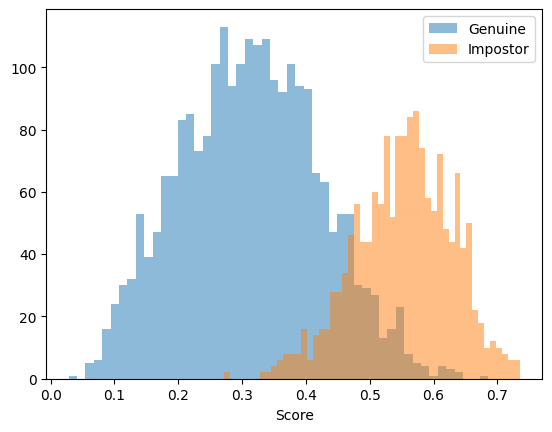

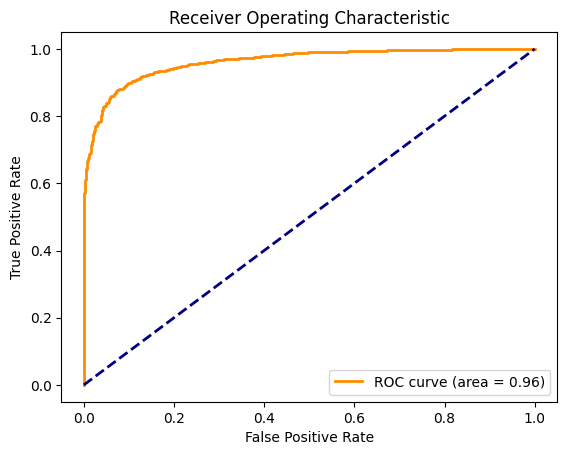

In [8]:

# Histograms
plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine')
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor')
plt.xlabel('Score')
plt.legend()
plt.show()

# ROC Curve
inverted_genuine = [1 - x for x in genuine_scores]
inverted_impostor = [1 - x for x in impostor_scores]

fpr, tpr, thresholds = roc_curve([0] * len(inverted_impostor) + [1] * len(inverted_genuine), inverted_impostor + inverted_genuine)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [9]:

# ROC AUC
print(f"ROC AUC: {roc_auc:.2f}")

# d-prime
genuine_mean = np.mean(inverted_genuine)
impostor_mean = np.mean(inverted_impostor)
genuine_std = np.std(inverted_genuine)
impostor_std = np.std(inverted_impostor)

d_prime = (genuine_mean - impostor_mean) / np.sqrt(0.5 * (genuine_std**2 + impostor_std**2))
print(f"d-prime: {d_prime:.2f}")


ROC AUC: 0.96
d-prime: 2.56
